### Brief description of the planned analysis

**Data sanity checks**

- compute the duration of the main session of the experiment per person
- plot duration over time (lineplot)
- check the number of trails each participant completed/condition -> which are missing?
- check the performance by condition
- screen size parameters -> plot
- screen timing -> mean refresh rates
- calibration parameters -> pix/degree, distance from phone ...

**Demographic Data**
- age distribution
- gender
- location in the world (map?)

**Data preprocessing**
- mean center x and y coordinates
    - individually for each of the 6 locations
- check outliers -> how many are there for each participant, color-code them

**Data Analysis Dip**
- individually compute movement rate
    - compute the trial number!
    - normalize to baseline, 100 ms before onset after doing the right trial correction
- from normalized baseline, compute:
    - minimum movement frequency
    - bottom of the dip - (baseline - min) + 0.1 * (baseline - min)
    - latency to maximum movement inhibition
    - magnitude of the inhibition
    - latency to 50% maximum inhibition
    - duration of the inhibition
- check deviation from baseline: baseline = no flash, no shift
- ANOVA: magnitude of the inhibition ~ (flash_condition x shift_condition)/subject
- ANOVA: duration of the inhibition ~ (flash_condition x shift_condition)/subject
- latency: MEASURE OF CLUTTERING?

**Data Analysis Error**
- compute the distance touch response -> corresponding dot (for shifted and non-shifted arrays)
- compute average error from non-shift trials
- compute -> does the order of the dots explain the error?
- linear model (y = a * x + b) 
- mean model of the data (y = b)
- subtract the error predicted by the model from the actual error.
- compute moving-window average error
- fit logistic regression:
        L/(1+e^(k(x-x0)))
        
        where L is the maximum error value, k the decay rate (steepness of the function) and x0 is the midpoint of the function (shift)

- parameters L, k, x0 -> ANOVA

**Quantify Improvement of Performance through inhibition**
- Given logistic regression -> estimated from participant
- What's the optimal duration, magnitude and latency for inhibition?
- response-generating function? 
- constraint by timing requirements
- Are the optimal values correlated with the actual values?

### Imports 

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Paths 

In [2]:
data_path = '../data/study_data_multiple_sessions/'
data_file = data_path + 'full_datafile.csv'
metadata_path = data_path + 'metadata_prolific/'

### Loading data

In [102]:
data = pd.read_csv(data_file)
# drop incomplete participants
data = data[data.prolific_id != '6129dc084c55f609fd62f0bc']
data = data[data.prolific_id != '5f9f4660d0edb75784c68223']


calibration_data = data[data.component == 'Calibrate_Screen'].copy()
training_data = data[data.component == 'Training_Serial'].copy()
main_session_data = data[data.component == 'Trials_Serial'].copy()
trial_data = main_session_data[main_session_data.test_part == 'trial'].dropna(axis = 1).copy()

# add a column for conditions
trial_data['condition'] = 'not defined'

flash_data = trial_data[trial_data.flashShown == 1]
noflash_data = trial_data[trial_data.flashShown == 0]

flash_shift_ids = flash_data[flash_data.stimJumped == 1].index
flash_noshift_ids = flash_data[flash_data.stimJumped == 0].index
noflash_shift_ids = noflash_data[noflash_data.stimJumped == 1].index
noflash_noshift_ids = noflash_data[noflash_data.stimJumped == 0].index

trial_data.loc[flash_shift_ids, 'condition'] = 'Flash_Shift'
trial_data.loc[flash_noshift_ids, 'condition'] = 'Flash_No_Shift'
trial_data.loc[noflash_shift_ids, 'condition'] = 'No_Flash_Shift'
trial_data.loc[noflash_noshift_ids, 'condition'] = 'No_Flash_No_Shift'

successfull_responses_data = trial_data[trial_data.success == 1].copy()
successfull_responses_data.reset_index(drop = True, inplace = True)
question_data = data[data.component == 'Trials_Serial'].copy()

### Duration of the main session

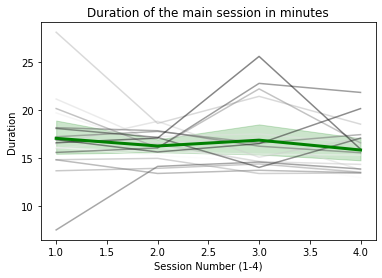

In [97]:
time_data = trial_data.groupby(['prolific_id', 'session_number']).describe()['time_elapsed']

elapsed_time = (time_data['max'] - time_data['min'])/60000
elapsed_time = elapsed_time.reset_index()

# plotting
duration_fig, duration_axs = plt.subplots(1,1)
sns.lineplot(data=elapsed_time, x="session_number", y=0, 
             hue="prolific_id", palette='Greys', alpha = 0.5, 
             legend = False, ax = duration_axs)

sns.lineplot(data=elapsed_time, x="session_number", y=0, 
             color='Green', linewidth = 3, legend = False, ax = duration_axs)

duration_axs.set_title('Duration of the main session in minutes')
duration_axs.set_xlabel('Session Number (1-4)')
duration_axs.set_ylabel('Duration');

### Missing data points

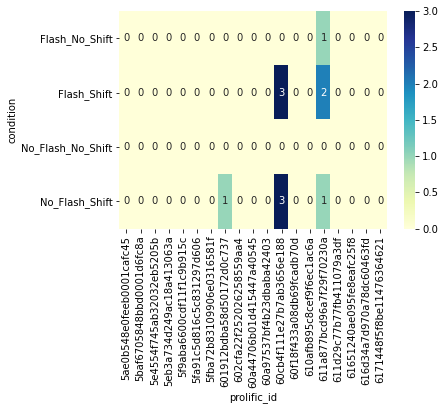

In [103]:
trial_count_data = successfull_responses_data.groupby(['prolific_id', 'condition']).describe()['success']
trial_count = 200 - trial_count_data['count']
trial_count = trial_count.reset_index()
trial_count = trial_count.pivot("condition", "prolific_id", "count")

sns.heatmap(trial_count, annot = True, cmap="YlGnBu");

### Performance by Condition

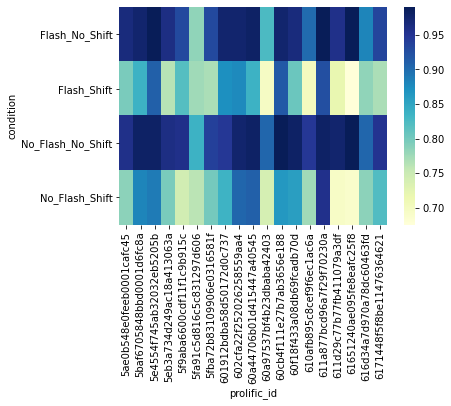

In [107]:
trial_performance_data = trial_data.groupby(['prolific_id', 'condition']).describe()['success']
trial_performance = trial_performance_data['mean']
trial_performance = trial_performance.reset_index()
trial_performance = trial_performance.pivot("condition", "prolific_id", "mean")

sns.heatmap(trial_performance, cmap="YlGnBu");

Performance differs by condition - with shift, performance is worse than without shift. 

- TODO: What causes the higher error rate? More missed responses or more delayed responses?

### Screen Parameters

#### Size

In [118]:
question_data.groupby('prolific_id').describe()[['windowWidth', 'windowHeight']]

windowWidth                                           \
                               count         mean         std     min     25%   
prolific_id                                                                     
5ae0b548e0feeb0001cafc45       921.0   836.000000    0.000000   836.0   836.0   
5baf6705848bbd0001d6fc8a       875.0   960.000000    0.000000   960.0   960.0   
5e4554f745ab32032eb5205b       851.0   692.000000    0.000000   692.0   692.0   
5eb3a734d249ac18a413063a       929.0   823.000000    0.000000   823.0   823.0   
5f9aba6600cdf11f1c9b915c       937.0   707.765208   74.715617   668.0   668.0   
5fa91c5d816c5c831297d606      1015.0  1153.875862  218.417647   776.0  1028.0   
5fba72b83109906e0316581f       938.0   830.682303   17.946896   792.0   839.0   
601912bdba58d50172d0c737       883.0   754.654587   10.867667   750.0   750.0   
602cfa22f252026258559aa4       859.0   755.000000    0.000000   755.0   755.0   
60a44706b01d415447a40545       867.0   750.000000    0.000000   750.0   750.0   
60a97537bf4b23dbaba42403      1020.0   681.000000    0.000000   681.0   681.0   
60cb4f111e27b7ab3656e188       850.0   729.129412   17.937063   360.0   730.0   
60f18f433a08db69fcadb70d       892.0  1024.000000    0.000000  1024.0  1024.0   
610afb895c8cef9f6ec1ac6a       976.0   817.000000    0.000000   817.0   817.0   
611a877bcd96a7f29f70230a       827.0   640.000000    0.000000   640.0   640.0   
611d29c77b77fb411079a3df       980.0   819.802041   24.328984   775.0   833.0   
61651240ae095fe8eafc25f8       990.0   726.000000    0.000000   726.0   726.0   
616d34a7d970a78dc60463fd       957.0   687.000000    0.000000   687.0   687.0   
6171448f5f8be11476364621       927.0   861.948220    1.576527   814.0   862.0   

                                                 windowHeight              \
                             50%     75%     max        count        mean   
prolific_id                                                                 
5ae0b548e0feeb0001cafc45   836.0   836.0   836.0        921.0  393.000000   
5baf6705848bbd0001d6fc8a   960.0   960.0   960.0        875.0  600.000000   
5e4554f745ab32032eb5205b   692.0   692.0   692.0        851.0  359.943596   
5eb3a734d249ac18a413063a   823.0   823.0   823.0        929.0  384.000000   
5f9aba6600cdf11f1c9b915c   668.0   668.0   848.0        937.0  367.290288   
5fa91c5d816c5c831297d606  1280.0  1280.0  1280.0       1015.0  698.123153   
5fba72b83109906e0316581f   839.0   839.0   839.0        938.0  386.923241   
601912bdba58d50172d0c737   750.0   750.0   780.0        883.0  360.000000   
602cfa22f252026258559aa4   755.0   755.0   755.0        859.0  360.000000   
60a44706b01d415447a40545   750.0   750.0   750.0        867.0  360.000000   
60a97537bf4b23dbaba42403   681.0   681.0   681.0       1020.0  359.733333   
60cb4f111e27b7ab3656e188   730.0   730.0   730.0        850.0  360.697647   
60f18f433a08db69fcadb70d  1024.0  1024.0  1024.0        892.0  600.000000   
610afb895c8cef9f6ec1ac6a   817.0   817.0   817.0        976.0  412.000000   
611a877bcd96a7f29f70230a   640.0   640.0   640.0        827.0  359.644498   
611d29c77b77fb411079a3df   833.0   833.0   833.0        980.0  405.628571   
61651240ae095fe8eafc25f8   726.0   726.0   726.0        990.0  360.000000   
616d34a7d970a78dc60463fd   687.0   687.0   687.0        957.0  360.000000   
6171448f5f8be11476364621   862.0   862.0   862.0        927.0  411.913700   

                                                                         
                                 std    min    25%    50%    75%    max  
prolific_id                                                              
5ae0b548e0feeb0001cafc45    0.000000  393.0  393.0  393.0  393.0  393.0  
5baf6705848bbd0001d6fc8a    0.000000  600.0  600.0  600.0  600.0  600.0  
5e4554f745ab32032eb5205b    1.162802  336.0  360.0  360.0  360.0  360.0  
5eb3a734d249ac18a413063a    0.000000  384.0  384.0  384.0  384.0  384.0  
5f9aba6600cdf11f1c9b915c   13